# Filter and split images

Now that we have the readable images, we will:
 - Filter out images that don't fit our desired dataset
 - Split data into training and testing folders

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
import pytesseract
from typing import Callable, Tuple, Dict
from collections import Counter
import shutil

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12


In [55]:
# NOTEBOOK PARAMETERS
src_path = '../datasets/pilot_resized'
src_metadata = '../datasets/pilot_resized/dataset_metadata.csv'

dest_path = '../datasets/pilot_final'
dest_metadata = '../datasets/pilot_final'

train_frac = 0.8 # Train-validation split frac
split_seed = 101 # Seed for random split

img_color_threshold = 0.1 # Parameter for filtering images in which the same color appears too often

## Set up dataset

In [5]:
def get_absolute_path(rel_path: str):
    return(str(Path(rel_path).resolve().absolute()))

src_path_full = get_absolute_path(src_path)
dest_path_full = get_absolute_path(dest_path)
print(src_path_full, '\n', dest_path_full)

/home/code/datasets/pilot_resized 
 /home/code/datasets/pilot_final


In [39]:
df_src = pd.read_csv(src_metadata, index_col=0)
df_ims = df_src[['new_full_path', 'new_image_dims', 'is_readable', 'full_path', 'image_dims']].rename({
    'new_full_path': 'full_path',
    'new_image_dims': 'image_dims',
    'full_path': 'original_path',
    'image_dims': 'original_image_dims'
}, axis=1)
df_ims['path_suffix'] = df_ims['full_path'].str.replace(src_path_full, '.')
df_ims['label'] = df_ims['full_path'].map(lambda im_path: Path(im_path).parts[-2])
df_ims.head()

,full_path,image_dims,is_readable,original_path,original_image_dims,path_suffix,label
name,,,,,,,
Blackberries_plant_1.jpg,/home/code/datasets/pilot_resized/negative/Bla...,"(399, 300)",True,/home/code/datasets/pilot_raw/negative/Blackbe...,"(1662, 1247)",./negative/Blackberries_plant_1.jpg,negative
Blackberries_plant_10.jpg,/home/code/datasets/pilot_resized/negative/Bla...,"(571, 300)",True,/home/code/datasets/pilot_raw/negative/Blackbe...,"(1200, 630)",./negative/Blackberries_plant_10.jpg,negative
Blackberries_plant_2.jpg,/home/code/datasets/pilot_resized/negative/Bla...,"(378, 300)",True,/home/code/datasets/pilot_raw/negative/Blackbe...,"(1556, 1234)",./negative/Blackberries_plant_2.jpg,negative
Blackberries_plant_3.jpg,/home/code/datasets/pilot_resized/negative/Bla...,"(300, 400)",True,/home/code/datasets/pilot_raw/negative/Blackbe...,"(450, 600)",./negative/Blackberries_plant_3.jpg,negative
Blackberries_plant_4.jpg,/home/code/datasets/pilot_resized/negative/Bla...,"(400, 300)",True,/home/code/datasets/pilot_raw/negative/Blackbe...,"(1280, 960)",./negative/Blackberries_plant_4.jpg,negative


## Get filter results

Goal: Get dataset of images which are just natural pictures of plants

Filters included:
 - Filter images which have too many identical pixel colors (likely a solid background, like a diagram not a natural photo)
 - Filter images with text detected (likely some kind of overlay or diagram, not just a normal nature photo)

 Not included is a "human filter"; originally tested to remove pics not of actual poison ivy (i.e. a person showing off a rash, not the plant itself). But the images seemed infrequent enough and the OpenCV results for human detection were not very good. Plus, people may be in the background when scanning a plant as poison ivy. So left this filter off.

In [40]:
# Filter application
def apply_filters_to_path(im_path:str,
                          filters: Dict[str, Callable[[np.ndarray], bool]],
                          passed_str:str = "Passed",
                          not_read_str:str = "Image_not_read") -> Tuple[bool, str]:
    """
    Apply a series of filters of to an image path
    By default checks if image can be read
    Then checks based on dictionary of {filter name: filter function}
    Returns a tuple of (Passed? (boolean), which filter failed or passed_str)
    """
    img = cv2.imread(im_path)
    if img is None:
        return (False, not_read_str) # Image could not be read
    
    for filter_name, filter_func in filters.items():
        if not filter_func(img):
            return (False, filter_name)
        
    return(True, passed_str) # No filters failed


# Filter 1 + helpers
def detect_image_text(img: np.ndarray) -> str:
    return(pytesseract.image_to_string(img, lang='eng').strip())

def filter_image_with_text(img: np.ndarray) -> bool:
    """
    Filter: Return True if text detected in image is blank
    """
    return(detect_image_text(img) == '')


# Filter 2 + helpers
def max_color_appearence_frac(img: np.ndarray) -> float:
    """
    Count the fraction of pixels which make up the most common color
    Detects if there is one color appearing too much (i.e. if there is a solid background instead of a more natural looking photo)
    """
    width, height, _ = img.shape
    return(max(Counter(tuple(img[i,j,:])
                       for i in range(width)
                       for j in range(height)).values()) / (height*width))

def filter_image_with_homogenous_color(img: np.ndarray, frac_threshold=0.1) -> bool:
    return(max_color_appearence_frac(img) < frac_threshold)

def create_homogenous_color_filter(frac_threshold=0.1):
    return(lambda img: filter_image_with_homogenous_color(img, frac_threshold=frac_threshold))

In [41]:
filters = {
    'homogenous_color': create_homogenous_color_filter(frac_threshold=img_color_threshold),
    'has_text': filter_image_with_text
}

df_ims['filter_results'] = df_ims['full_path'].map(lambda im_path: apply_filters_to_path(im_path, filters))

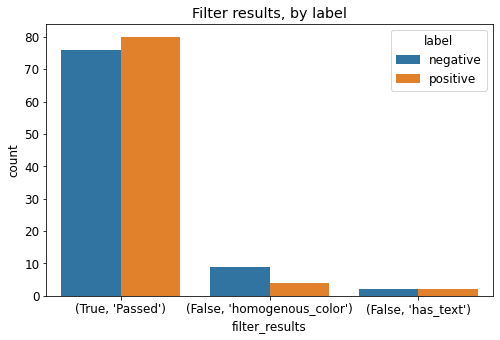

In [49]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_ims, x='filter_results', hue='label')
plt.title("Filter results, by label")
plt.show()

In [51]:
df_ims['keep_image'] = df_ims['filter_results'].map(lambda res_vals: res_vals[0])
df_keep = df_ims[df_ims['keep_image']]
print(len(df_keep.index))

156


## Split data

In [56]:
train_ims, val_ims = train_test_split(df_keep.index, stratify=df_keep['label'], train_size=train_frac, random_state=split_seed)

<AxesSubplot:xlabel='split', ylabel='count'>

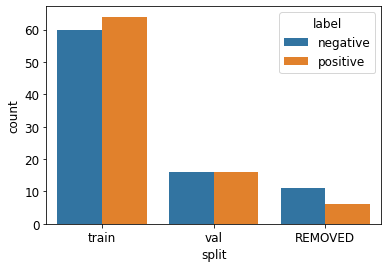

In [60]:
df_ims['split'] = 'REMOVED'
df_ims.loc[train_ims, 'split'] = 'train'
df_ims.loc[val_ims, 'split'] = 'val'

sns.countplot(data=df_ims, x='split', hue='label')

In [63]:
keep_ims = df_ims[df_ims['keep_image']].index

df_ims.loc[keep_ims, 'new_full_path'] = df_ims.loc[keep_ims].apply(
    lambda row: str(Path(dest_path_full, row['split'], row['path_suffix']).resolve().absolute()),
    axis=1
)

## Store everything in final location

In [68]:
# Store images in appropriate locations
for name, im_data in df_ims[df_ims['keep_image']].iterrows():
    input_path = im_data['full_path']
    output_path = im_data['new_full_path']
    Path(output_path).parents[0].mkdir(exist_ok=True, parents=True)
    shutil.copy(input_path, output_path)
    